In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, f1_score, jaccard_score, precision_score
import pandas as pd
import seaborn as sn
import torch.nn.functional as F
import sklearn.metrics as skmt
import itertools
# from tqdm import tqdm


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!mkdir covid_data

In [0]:
from google.colab import drive
drive.mount("./gdrive")
!unzip "./gdrive/My Drive/Copy of A_05_Part_02_Dataset.zip" -d covid_data;

In [0]:
!nvidia-smi

### Load Dataset usign torchvision image loader

In [0]:
data_dir = 'covid_data/A_05_Part_02_Dataset'

In [0]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        label = original_tuple[1]
        if self.classes[label] == 'normal':
            alabel = torch.LongTensor([0, 1, 0])
        elif self.classes[label] == 'covid-19':
            alabel = torch.LongTensor([1, 0, 1])
        elif self.classes[label] == 'pneumonia':
            alabel = torch.LongTensor([0, 0, 1])
        return original_tuple[0], alabel

In [86]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = ImageFolderWithPaths(data_dir + '/Train', transform=train_transforms)
val_data = ImageFolderWithPaths(data_dir + '/Validation', transform=val_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=60, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


In [87]:
print(train_data)
print(val_data)

Dataset ImageFolderWithPaths
    Number of datapoints: 6200
    Root location: covid_data/A_05_Part_02_Dataset/Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-30, 30), resample=False, expand=False)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolderWithPaths
    Number of datapoints: 628
    Root location: covid_data/A_05_Part_02_Dataset/Validation
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


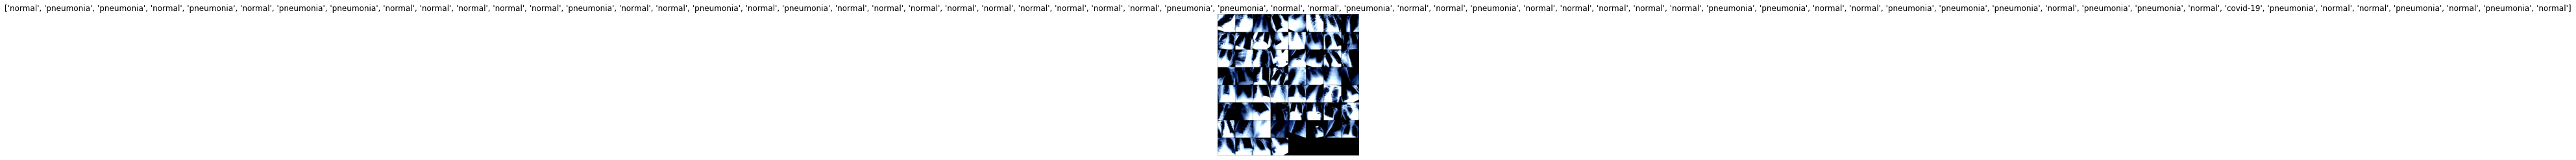

In [29]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)


## Evaluation and Stats Printing

In [0]:
def compute_acc_and_loss(model, criterion, loader):
    model.eval()
    actual_labels = []
    predic_labels = []

    with torch.no_grad():
        for data in loader:
            
            images, labels = data
            images = images.to(device) 
            labels = labels.to(device)
            outputs = model(images)
            labels = labels.type_as(outputs)
            actual_labels.extend(labels)
            predic_labels.extend(outputs)
    actual_labels = torch.stack(actual_labels)
    predic_labels = torch.stack(predic_labels)

    loss = criterion(predic_labels, actual_labels)
    acc = skmt.jaccard_score(actual_labels.cpu().numpy(), torch.round(torch.sigmoid(predic_labels)).cpu().numpy(), average = 'samples')
    return acc*100, loss.item()

In [0]:
def print_stats(model, loader):

    model.eval()
    actual_labels = []
    predic_labels = []

    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            actual_labels.extend(labels)
            predic_labels.extend(outputs)

    actual_labels = torch.stack(actual_labels).cpu().numpy()
    predic_labels = torch.round(torch.sigmoid(torch.stack(predic_labels))).cpu().numpy()

    accuracy = skmt.jaccard_score(actual_labels, predic_labels, average = 'samples')
    precesion = skmt.precision_score(actual_labels, predic_labels, average = 'samples')
    recall = skmt.recall_score(actual_labels, predic_labels, average = 'samples')
    f1_score = skmt.f1_score(actual_labels, predic_labels, average = 'samples')
    
    print(' Accuracy : %.2f %%' %(accuracy) )
    print(' F1 Score : %.2f %%' %(f1_score))
    print(' Precesion : %.2f %%' %(precesion))
    print(' Recall : %.2f %%' %(recall))

    conf  = skmt.multilabel_confusion_matrix(actual_labels, predic_labels)
    df_cm = pd.DataFrame(conf[2].astype(int), columns=['diseased', 'normal'], index = ['diseased', 'normal'])
    df_cm.index.name = 'True'
    df_cm.columns.name = 'Predicted'
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 10}, fmt="d")
    plt.show()

    df_cm = pd.DataFrame(conf[1].astype(int), columns=['non-pneumonia', 'pneumonia',], index = ['non-pneumonia', 'pneumonia',])
    df_cm.index.name = 'True'
    df_cm.columns.name = 'Predicted'
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 10}, fmt="d")
    plt.show()

    df_cm = pd.DataFrame(conf[0].astype(int), columns=['non-covid', 'covid'], index = ['non-covid', 'covid'])
    df_cm.index.name = 'True'
    df_cm.columns.name = 'Predicted'
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 10}, fmt="d")
    plt.show()

# Task 1 with BCE loss

## VGG16

In [88]:
vgg16 = models.vgg16(pretrained=True)
num_features = vgg16.classifier[0].in_features
features = vgg16.classifier[:3]
features[0] = nn.Linear(in_features=num_features, out_features=110)
features[2] = nn.Linear(in_features=110, out_features=3)
vgg16.classifier = nn.Sequential(*features)
out_dir = './gdrive/My Drive/Deep Learning Assignment 5b/models/task1/'

total_params = sum(p.numel() for p in vgg16.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in vgg16.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

17,474,811 total parameters.
17,474,811 training parameters.


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

In [0]:
from torchvision import models
from torchsummary import summary
summary(vgg16, (3, 224, 224))

### Loss fucntion and optimizer

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

### Training

In [0]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

acc, loss = compute_acc_and_loss(vgg16, criterion, trainloader)
train_acc.append(acc)
train_loss.append(loss)

acc, loss = compute_acc_and_loss(vgg16, criterion, valloader)
val_acc.append(acc)
val_loss.append(loss)


In [107]:
for epoch in range(14,Epochs+5):  # loop over the dataset multiple times
    vgg16.train()
    running_loss = 0.0
    running_acc = 0.0

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vgg16(inputs)               #----> forward pass
        labels = labels.type_as(outputs)
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        acc = skmt.jaccard_score(labels.detach().cpu().numpy(), torch.round(torch.sigmoid(outputs)).detach().cpu().numpy(), average = 'samples')

        running_loss += loss.item()
        running_acc += acc
    
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)] \t\
             Loss:{:.6f}  \
             Acc:{:.2f}   \
             RunningLoss:{:.6f}   \
             RunningAcc:{:.2f}'.format(
             epoch, i * len(inputs), len(trainloader.dataset),
             100. * i / len(trainloader),
             loss.item(),
             acc.item(),
             running_loss,
             running_acc/(i+1)))

    acc, loss = compute_acc_and_loss(vgg16, criterion, trainloader)
    train_acc.append(acc)
    train_loss.append(loss)

    acc, loss = compute_acc_and_loss(vgg16, criterion, valloader)
    val_acc.append(acc)
    val_loss.append(loss)

    print('Train Epoch: {} Train Accuracy: {:.2f} Train Loss : {:.6f} \t Validation Accuracy: {:.2f}  Validation Loss : {:.6f} '.format( epoch, 
                            train_acc[epoch+1], train_loss[epoch+1], 
                            val_acc[epoch+1], val_loss[epoch+1]))

    torch.save(vgg16.state_dict(), out_dir + 'vgg16_ft_' + str(epoch) +  '.pth')

print('Finished Training')


Train Epoch: 14 Train Accuracy: 91.45 Train Loss : 0.153661 	 Validation Accuracy: 93.07  Validation Loss : 0.158548 
Finished Training


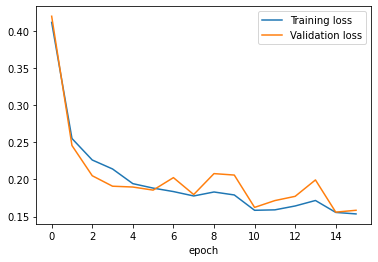

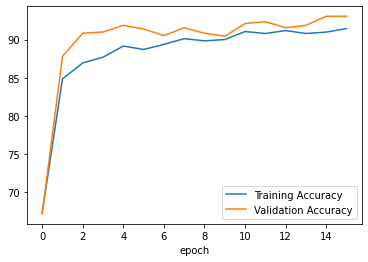

In [108]:
plt.figure()
plt.plot(train_loss, label = "Training loss")
plt.plot(val_loss, label = "Validation loss")
plt.xlabel("epoch")
plt.legend(loc='best')

plt.figure()
plt.plot(train_acc, label = "Training Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.xlabel("epoch")
plt.legend(loc='best')


### Testing

Training Dataset: 
 Accuracy : 0.92 %
 F1 Score : 0.92 %
 Precesion : 0.92 %
 Recall : 0.92 %


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


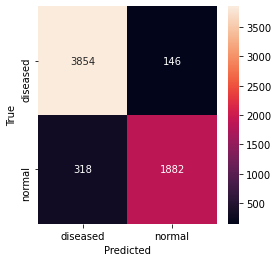

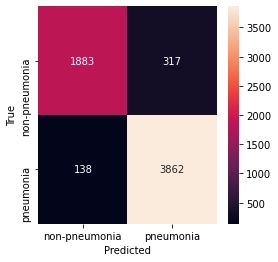

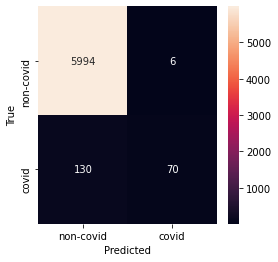

Validation Dataset: 
 Accuracy : 0.93 %
 F1 Score : 0.93 %
 Precesion : 0.94 %
 Recall : 0.93 %


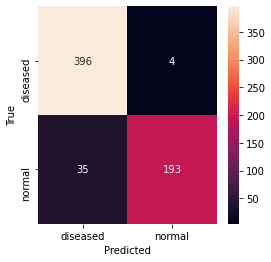

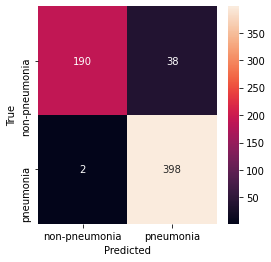

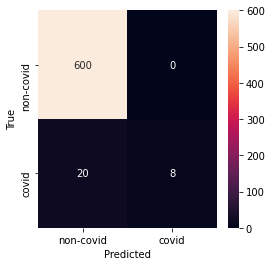

In [150]:
print('Training Dataset: ')
print_stats(vgg16, trainloader)
print('Validation Dataset: ')
print_stats(vgg16, valloader)

## Resnet

In [0]:
resnet18 = models.resnet18(pretrained=True)
fc_layers = []
fc_layers.extend([nn.Linear(in_features=512, out_features=110)])
fc_layers.extend([nn.ReLU(inplace=True)])
fc_layers.extend([nn.Linear(in_features=110, out_features=3)])
resnet18.fc = nn.Sequential(*fc_layers)
out_dir = './gdrive/My Drive/Deep Learning Assignment 5b/models/task1/'

total_params = sum(p.numel() for p in resnet18.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in resnet18.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

### Training

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [0]:
rtrain_loss = []
rval_loss = []
rtrain_acc = []
rval_acc = []

acc, loss = compute_acc_and_loss(resnet18, criterion, trainloader)
rtrain_acc.append(acc)
rtrain_loss.append(loss)

acc, loss = compute_acc_and_loss(resnet18, criterion, valloader)
rval_acc.append(acc)
rval_loss.append(loss)

In [154]:
for epoch in range(19,Epochs+10):  # loop over the dataset multiple times
    resnet18.train()
    running_loss = 0.0
    running_acc = 0.0

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet18(inputs)               #----> forward pass
        labels = labels.type_as(outputs)
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        acc = skmt.jaccard_score(labels.detach().cpu().numpy(), torch.round(torch.sigmoid(outputs)).detach().cpu().numpy(), average = 'samples')

        running_loss += loss.item()
        running_acc += acc
    
        pbar.set_description(
        'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, i * len(inputs), len(trainloader.dataset),
            100. * i / len(trainloader),
            loss.item()));

    acc, loss = compute_acc_and_loss(resnet18, criterion, trainloader)
    rtrain_acc.append(acc)
    rtrain_loss.append(loss)

    acc, loss = compute_acc_and_loss(resnet18, criterion, valloader)
    rval_acc.append(acc)
    rval_loss.append(loss)

    print('Train Epoch: {} Train Accuracy: {:.2f} Train Loss : {:.6f} \t Validation Accuracy: {:.2f}  Validation Loss : {:.6f} '.format( epoch, 
                            rtrain_acc[epoch+1], rtrain_loss[epoch+1], 
                            rval_acc[epoch+1], rval_loss[epoch+1]))

    torch.save(resnet18.state_dict(), out_dir + 'resnet18_ft_' + str(epoch) +  '.pth')

print('Finished Training')


Train Epoch: 19 Train Accuracy: 92.23 Train Loss : 0.143753 	 Validation Accuracy: 94.11  Validation Loss : 0.132727 
Finished Training


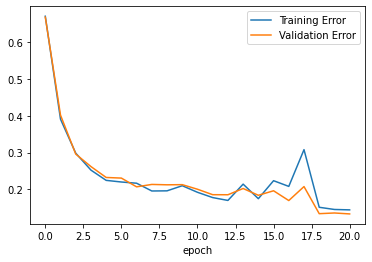

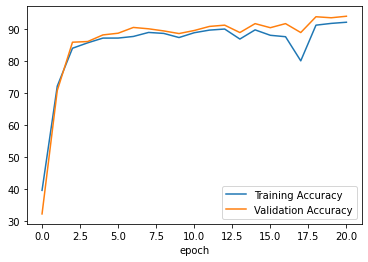

In [155]:
plt.figure()
plt.plot(rtrain_loss, label = "Training Error")
plt.plot(rval_loss, label = "Validation Error")
plt.xlabel("epoch")
plt.legend(loc='best')

plt.figure()
plt.plot(rtrain_acc, label = "Training Accuracy")
plt.plot(rval_acc, label = "Validation Accuracy")
plt.xlabel("epoch")
plt.legend(loc='best')

### Testing

Training Dataset: 
 Accuracy : 0.92 %
 F1 Score : 0.92 %
 Precesion : 0.92 %
 Recall : 0.92 %


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


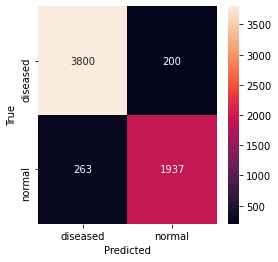

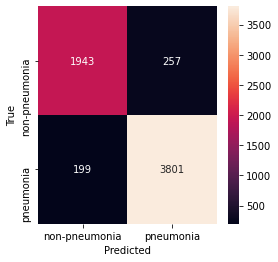

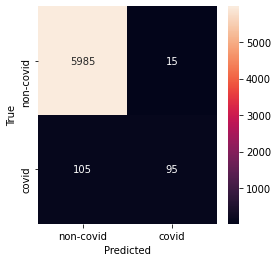

Validation Dataset: 
 Accuracy : 0.94 %
 F1 Score : 0.94 %
 Precesion : 0.95 %
 Recall : 0.94 %


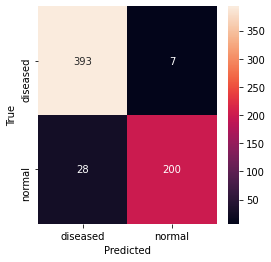

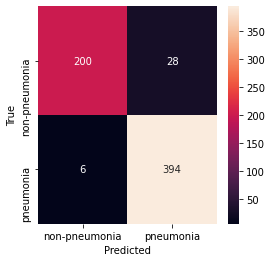

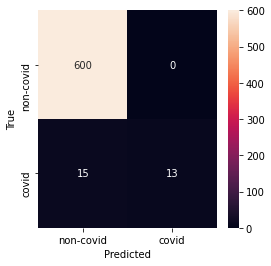

In [157]:
print('Training Dataset: ')
print_stats(resnet18, trainloader)
print('Validation Dataset: ')
print_stats(resnet18, valloader)

# Task 1 with Focal loss

## Focal Loss Function Overwrite

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction= 'sum'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        p = torch.sigmoid(inputs)
        y = targets
        alpha = self.alpha
        gamma = self.gamma
        if self.reduction == 'mean':
            return -torch.mean(y*alpha*(1-p)**gamma*torch.log(p) + (1-y)*(1-alpha)*(p)**gamma*torch.log(1-p))
        elif self.reduction == 'sum':
            return -torch.sum(y*alpha*(1-p)**gamma*torch.log(p) + (1-y)*(1-alpha)*(p)**gamma*torch.log(1-p))
        else:
            return  -1* (y*alpha*(1-p)**gamma*torch.log(p) + (1-y)*(1-alpha)*(p)**gamma*torch.log(1-p))

## VGG16 

In [0]:
vgg16 = models.vgg16(pretrained=True)
num_features = vgg16.classifier[0].in_features
features = vgg16.classifier[:3]
features[0] = nn.Linear(in_features=num_features, out_features=110)
features[2] = nn.Linear(in_features=110, out_features=3)
vgg16.classifier = nn.Sequential(*features)
out_dir = './gdrive/My Drive/Deep Learning Assignment 5b/models/task2/'

total_params = sum(p.numel() for p in vgg16.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in vgg16.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

### Training

In [0]:
Epochs = 10
criterion = FocalLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)

In [0]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

acc, loss = compute_acc_and_loss(vgg16, criterion, trainloader)
train_acc.append(acc)
train_loss.append(loss)

acc, loss = compute_acc_and_loss(vgg16, criterion, valloader)
val_acc.append(acc)
val_loss.append(loss)

In [0]:
epoch = 0
print('Train Epoch: {} Train Accuracy: {:.2f} Train Loss : {:.6f} \t Validation Accuracy: {:.2f}  Validation Loss : {:.6f} '.format( epoch, 
                        train_acc[epoch], train_loss[epoch], 
                        val_acc[epoch], val_loss[epoch]))


Train Epoch: 0 Train Accuracy: 39.40 \Train Loss : 0.097343 	 Validation Accuracy: 43.18  Validation Loss : 0.096900 


In [0]:
for epoch in range(25, Epochs+16):  # loop over the dataset multiple times
    vgg16.train()
    running_loss = 0.0
    running_acc = 0.0

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vgg16(inputs)               #----> forward pass
        labels = labels.type_as(outputs)
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        acc = skmt.jaccard_score(labels.detach().cpu().numpy(), torch.round(torch.sigmoid(outputs)).detach().cpu().numpy(), average = 'samples')

        running_loss += loss.item()
        running_acc += acc
    
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()));

    acc, loss = compute_acc_and_loss(vgg16, criterion, trainloader)
    train_acc.append(acc)
    train_loss.append(loss)

    acc, loss = compute_acc_and_loss(vgg16, criterion, valloader)
    val_acc.append(acc)
    val_loss.append(loss)

    print('Train Epoch: {} Train Accuracy: {:.2f} Train Loss : {:.6f} \t Validation Accuracy: {:.2f}  Validation Loss : {:.6f} '.format( epoch, 
                            train_acc[epoch+1], train_loss[epoch+1], 
                            val_acc[epoch+1], val_loss[epoch+1]))

    torch.save(vgg16.state_dict(), out_dir + 'vgg16_ft_' + str(epoch) +  '.pth')

print('Finished Training')

Train Epoch: 25 Train Accuracy: 84.15 Train Loss : 354.447632 	 Validation Accuracy: 89.41  Validation Loss : 32.718002 
Finished Training


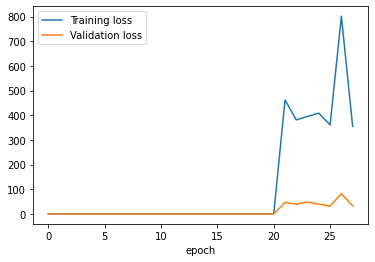

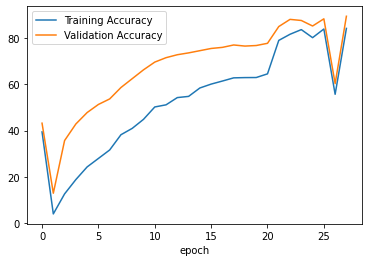

In [0]:
plt.figure()
plt.plot(train_loss, label = "Training loss")
plt.plot(val_loss, label = "Validation loss")
plt.xlabel("epoch")
plt.legend(loc='best')

plt.figure()
plt.plot(train_acc, label = "Training Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.xlabel("epoch")
plt.legend(loc='best')


### Testing

Training Dataset: 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 Accuracy : 0.83 %
 F1 Score : 0.84 %
 Precesion : 0.84 %
 Recall : 0.83 %


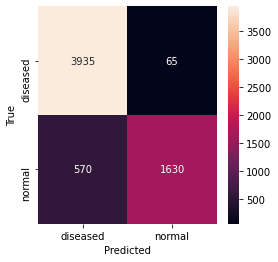

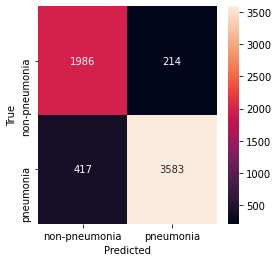

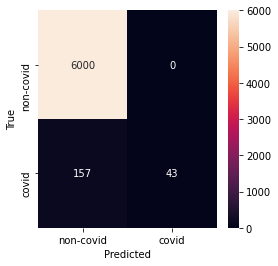

Validation Dataset: 
 Accuracy : 0.89 %
 F1 Score : 0.90 %
 Precesion : 0.90 %
 Recall : 0.89 %


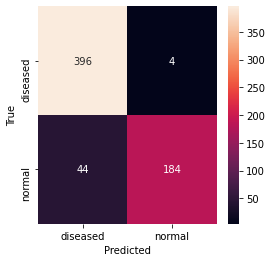

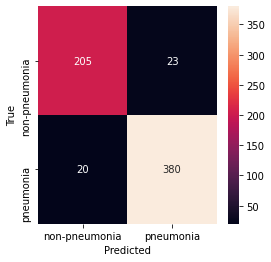

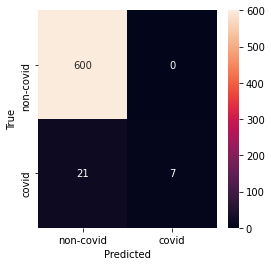

In [0]:
print('Training Dataset: ')
print_stats(vgg16, trainloader)
print('Validation Dataset: ')
print_stats(vgg16, valloader)

## Resnet

In [0]:
resnet18 = models.resnet18(pretrained=True)
fc_layers = []
fc_layers.extend([nn.Linear(in_features=512, out_features=110)])
fc_layers.extend([nn.ReLU(inplace=True)])
fc_layers.extend([nn.Linear(in_features=110, out_features=3)])
resnet18.fc = nn.Sequential(*fc_layers)
out_dir = './gdrive/My Drive/Deep Learning Assignment 5b/models/task2/'

total_params = sum(p.numel() for p in resnet18.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in resnet18.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

### Training

In [0]:
Epochs = 10
criterion = FocalLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.00005, momentum=0.9)

In [0]:
rtrain_loss = []
rval_loss = []
rtrain_acc = []
rval_acc = []

acc, loss = compute_acc_and_loss(resnet18, criterion, trainloader)
rtrain_acc.append(acc)
rtrain_loss.append(loss)

acc, loss = compute_acc_and_loss(resnet18, criterion, valloader)
rval_acc.append(acc)
rval_loss.append(loss)

In [165]:
epoch = 0
print('Train Epoch: {} Train Accuracy: {:.2f} Train Loss : {:.6f} \t Validation Accuracy: {:.2f}  Validation Loss : {:.6f} '.format( epoch, 
                        train_acc[epoch], train_loss[epoch], 
                        val_acc[epoch], val_loss[epoch]))


Train Epoch: 0 Train Accuracy: 67.22 Train Loss : 0.411420 	 Validation Accuracy: 67.09  Validation Loss : 0.419688 


In [193]:
for epoch in range(21,Epochs+12):  # loop over the dataset multiple times
    resnet18.train()
    running_loss = 0.0
    running_acc = 0.0

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet18(inputs)               #----> forward pass
        labels = labels.type_as(outputs)
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        acc = skmt.jaccard_score(labels.detach().cpu().numpy(), torch.round(torch.sigmoid(outputs)).detach().cpu().numpy(), average = 'samples')

        running_loss += loss.item()
        running_acc += acc
    
        pbar.set_description(
        'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, i * len(inputs), len(trainloader.dataset),
            100. * i / len(trainloader),
            loss.item()));

    acc, loss = compute_acc_and_loss(resnet18, criterion, trainloader)
    rtrain_acc.append(acc)
    rtrain_loss.append(loss)

    acc, loss = compute_acc_and_loss(resnet18, criterion, valloader)
    rval_acc.append(acc)
    rval_loss.append(loss)

    print('Train Epoch: {} Train Accuracy: {:.2f} Train Loss : {:.6f} \t Validation Accuracy: {:.2f}  Validation Loss : {:.6f} '.format( epoch, 
                            rtrain_acc[epoch+1], rtrain_loss[epoch+1], 
                            rval_acc[epoch+1], rval_loss[epoch+1]))

    torch.save(resnet18.state_dict(), out_dir + 'resnet18_ft_' + str(epoch) +  '.pth')

print('Finished Training')


Train Epoch: 21 Train Accuracy: 87.49 Train Loss : 266.967224 	 Validation Accuracy: 89.97  Validation Loss : 30.500584 
Finished Training


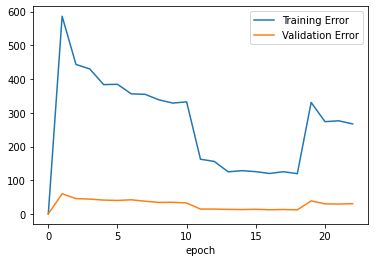

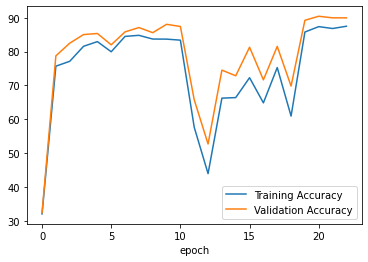

In [194]:
plt.figure()
plt.plot(rtrain_loss, label = "Training Error")
plt.plot(rval_loss, label = "Validation Error")
plt.xlabel("epoch")
plt.legend(loc='best')

plt.figure()
plt.plot(rtrain_acc, label = "Training Accuracy")
plt.plot(rval_acc, label = "Validation Accuracy")
plt.xlabel("epoch")
plt.legend(loc='best')

### Testing

Training Dataset: 
 Accuracy : 0.87 %
 F1 Score : 0.87 %
 Precesion : 0.88 %
 Recall : 0.87 %


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


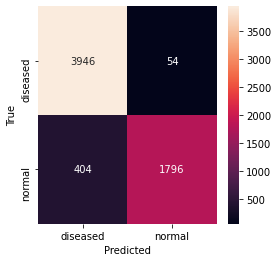

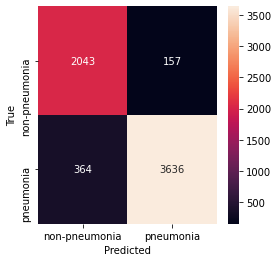

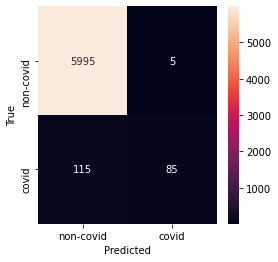

Validation Dataset: 
 Accuracy : 0.90 %
 F1 Score : 0.90 %
 Precesion : 0.91 %
 Recall : 0.90 %


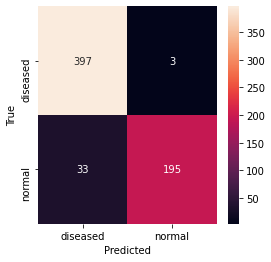

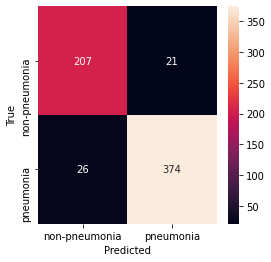

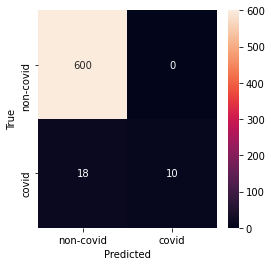

In [200]:
print('Training Dataset: ')
print_stats(resnet18, trainloader)
print('Validation Dataset: ')
print_stats(resnet18, valloader)

# Best Model Accuracy on Test Set 

In [0]:
class TestImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(TestImageFolderWithPaths, self).__getitem__(index)
        return original_tuple[0], self.imgs[index] # path

In [0]:
resnet18 = models.resnet18(pretrained=True)
fc_layers = []
fc_layers.extend([nn.Linear(in_features=512, out_features=110)])
fc_layers.extend([nn.ReLU(inplace=True)])
fc_layers.extend([nn.Linear(in_features=110, out_features=3)])
resnet18.fc = nn.Sequential(*fc_layers)
out_dir = './gdrive/My Drive/Deep Learning Assignment 5b/models/task1/'
weights_path = out_dir + 'resnet18_ft_' + str(19) +  '.pth'
resnet18.load_state_dict(torch.load(weights_path))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
!mkdir testset
!cp -r 'covid_data/A_05_Part_02_Dataset/Test/' 'testset/'


In [13]:
test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

data_dir = './'
print("Data Loading")
test_data = TestImageFolderWithPaths(data_dir + 'testset/', transform=test_transforms)
print(test_data)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
print("Data Loaded")

resnet18.eval()
paths = []
ff = open('MSCS19001_results.csv', 'w')
with torch.no_grad():
    for data in testloader:
        images, path = data
        images =  images.to(device)
        outputs = resnet18(images)
        outputs = torch.round(torch.sigmoid(outputs)).cpu().numpy()
        name = os.path.split(path[0][0])[1]
        ff.write(name + ',' + str(int(outputs[0,0])) + ',' + str(int(outputs[0,1])) + ',' + str(int(outputs[0,2])) + '\n')
print("Finished Prediction")

Data Loading
Dataset TestImageFolderWithPaths
    Number of datapoints: 629
    Root location: ./testset/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Data Loaded
Finished Prediction
